# Piecewise Regression

Piecewise regression is a model in which the independent variable is partitioned into intervals, and the dependent variable is a piecewise linear function of the independent variable.

In this tutorial, we will implement piecewise regression and train it using SVI. Then we will look at exploiting the piecewise structure of the model for more robust and efficient inference.

### Tutorial Outline

### Setup

In [2]:
from tqdm import tqdm
import torch
import pyro
from pyro.distributions import *
from pyro.infer import SVI, Trace_ELBO

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_sample

import matplotlib.pyplot as plt

In [3]:
pyro.set_rng_seed(0)

### Synthetic data

Let's generate some piecewise linear data. First let's sample the independent variable, slopes, breakpoints (or knots), the observation noise level and the first intercept.

In [4]:
n_pieces = 5
N = 700
x = torch.rand(N).sort()[0]*100
slopes = Uniform(-3,3).sample([n_pieces])
knots,_ = Uniform(0,N).sample([n_pieces-1]).sort()
knots = knots.long()
intercepts = [Uniform(-10,10).sample()]
y_noise = 3.

Now, let's sample the dependent variable for each piece, solving for the intercept such that the pieces are connected.

In [5]:
y = []
prev_knot = 0
for i,knot in enumerate(knots):
    y.append(Normal(slopes[i]*x[prev_knot:knot]+intercepts[i],y_noise).sample())
    intercepts.append(slopes[i]*x[knot]+intercepts[i] - slopes[i+1]*x[knot])
    prev_knot = knot
    
y.append(Normal(slopes[-1]*x[knots[-1]:]+intercepts[-1],y_noise).sample())
y = torch.cat(y)

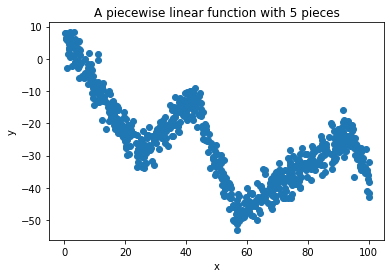

In [7]:
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'A piecewise linear function with {n_pieces} pieces');

### Model

As above, the model should sample the various parameters, and produce piecewise linear data. But we'd like to vectorize the model, in order to efficiently compute low-variance ELBO gradient estimates during inference.
* We already know the x-coordinates of the first and last knot, which we get from the smallest and largest observed x. So we sample the x-coordinate for the knots in the middle, and the y-coordinates for all knots. 
* To avoid optimizing over a large parameter space, we scale the knot coordinates down, such that the x-coordinates take values in the unit interval, and the y-coordinates are standard Normal distributed.
* Given the knot coordinates, we need to evaluate the piecewise linear function in a vectorized manner. We do this by constructing arrays which, for each observed data-point, contain the coordinates of the knots which define the piece to which the data-point belongs. We can then compute the slopes in one line and likewise the intercepts.
* Having evaluated the mean of the data, we sample the observations from a Normal distribution with a LogNormal-distributed scale parameter.

In [6]:
def piecewise_eval(knot_x, knot_y, x):
    n_knots = knot_x.size(-1)
    assert n_knots >= 2
    knot_x, idx = knot_x.sort(dim=-1)
    knot_y = knot_y.gather(-1,idx)
    lb = (x.unsqueeze(-1) > knot_x[...,1:].unsqueeze(-2)).long().sum(-1)
    lb[lb >= n_knots - 1] = n_knots - 2
    ub = lb + 1
    x0 = knot_x.gather(-1,lb)
    x1 = knot_x.gather(-1,ub)
    y0 = knot_y.gather(-1,lb)
    y1 = knot_y.gather(-1,ub)
    slopes = (y1-y0)/(x1-x0).clamp(min=1e-8)
    return slopes*x + (y1 - slopes*x1)

In [7]:
def piecewise_regression(x, y, n_knots=3):
    x_knot_prior = Uniform(0, 1)
    knot_x = pyro.sample("knot_x",
                         x_knot_prior
                             .expand([n_knots]).to_event(0))
    knot_y = pyro.sample("knot_y",
                         Normal(0, 1)
                             .expand([n_knots]).to_event(0))
    x_len = x.max()-x.min()
    y_pred = piecewise_eval(x_len*knot_x, x_len*knot_y, x)
    y_scale = pyro.sample("y_scale", LogNormal(0, 1))
    y = pyro.sample("obs", Normal(y_pred, y_scale),
                obs=y)
    return y

### Inference

For inference, we use an AutoGuide, and optimize the ELBO as a function of the guide's parameters with Adam.

In [8]:
guide = AutoDiagonalNormal(piecewise_regression,init_loc_fn=init_to_sample)

In [9]:
pyro.clear_param_store()

In [10]:
optim = pyro.optim.Adam({"lr": 0.05})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, guide, optim, loss=elbo)

In [11]:
n_knots = n_pieces + 1
losses = []
for i in tqdm(range(50000)):
    losses.append(svi.step(x,y,n_knots))

100%|██████████| 60000/60000 [05:51<00:00, 170.87it/s]


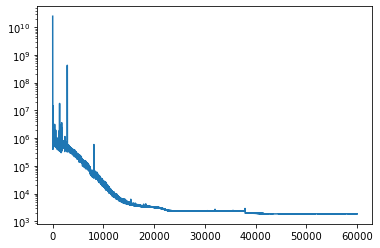

In [12]:
plt.plot(losses)
plt.yscale('log')

In [13]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

<ErrorbarContainer object of 3 artists>

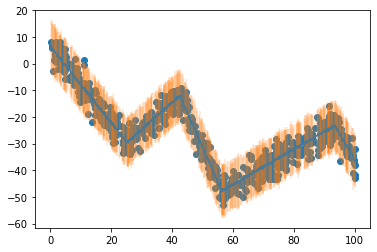

In [14]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)